In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.executing_eagerly()

True

# Parameter estimation in Bayesian linear regression
In this notebook we are going to show how parameter estimation is done using **maximum a posteriori** (MAP) and see how this technique differs from maximum likelihood (MLE). The case study will be to estimate parameters in bayesian linear regression problem.

In [2]:
tf.random.set_seed(4)
# Generate some data
noise = tf.random.normal((100,1), mean=0.0, stddev=1.0)
X = tf.linspace(0., 3., 100)
Y = tf.squeeze(1+noise)*X-3

# Define model and its constituents (as normal random variables)
b0_v = tf.Variable(0.0)
b1_v = tf.Variable(0.0)
model = tfd.JointDistributionSequential([
    tfd.Normal(name = "b0", loc=b0_v, scale=1.0),
    tfd.Normal(name = "b1", loc=b1_v, scale=1.0),
    lambda b1, b0: tfd.Independent(tfd.Normal(loc = b0 + b1*X, scale=5.0), reinterpreted_batch_ndims=1)])

The model is built as a joint distribution between the data and their parameters. We assume the parameters of the linear regression model `b0` and `b1` are random variables that follow a Normal distribution. For the sake of simplicity, we assume the parameters' standard deviation remain constant over the whole learning process.

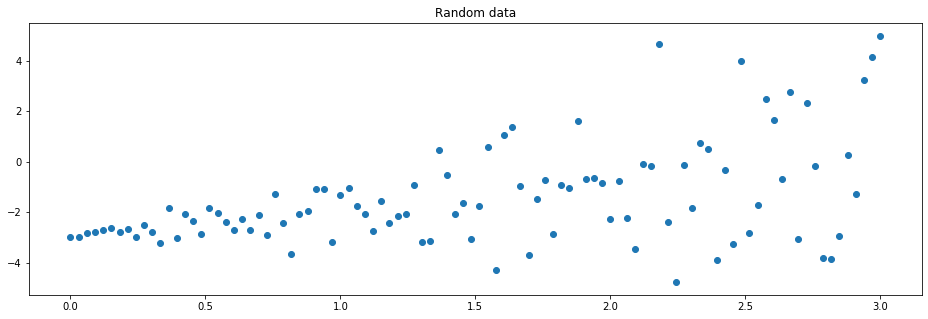

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting data
fig, ax = plt.subplots(figsize=(16,5))
plt.scatter(X,Y)
plt.title("Random data");

To see the difference between MAP and MLE we need to take a look at the Bayes' theorem:

$$ 
P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

In this case study we will focus exactly on:

* $ P(D|\theta)$ is the likelihood function, given the current value of the parameters it measures the likelihood that the data has been generated thanks to them. Maximizing this component means we will estimate the parameters with MLE.
* $ P(\theta|D)$ is the posterior probability, for which given the data, we measure the probability that data has been generated for a certain set of parameters. Maximizin this component means we will estimate the parameters through MAP.

Two things to pinpoint are:
* Data never gets updated, only the parameters are updated
* For our problem the relationship between data and parameters is defined with the Normal probability density function (PDF)

In [4]:
from functools import partial

def loss_MAP(model, data):
    total_log_prob = -tf.reduce_mean(model.log_prob([b0_v, b1_v, data])) - tf.reduce_mean(model.log_prob_parts([b0_v, b1_v, data])[:-1])
    return(total_log_prob)

def loss_MLE(model, data):
    total_log_prob = -tf.reduce_mean(model.log_prob([b0_v, b1_v, data]))
    return(total_log_prob)

def grad(model, inputs,loss_func):
    with tf.GradientTape() as tape:
        loss_value = loss_func(model, inputs)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

grad_func = partial(grad, model, Y)

As you can see, what changes MAP from MLE is that we need to add the prior probability of the parameters into the cost function. The fact that `b0` and `b1` are independent makes it easy to do the calculation.

In [5]:
b0_comparison = {}
b1_comparison = {}
optimizer = tf.optimizers.Adam(0.01)

## Parameter estimation with MAP

In [6]:
opt_list = []
prob_values = []

for i in range(1000):
    loss_value, grads = grad_func(loss_MAP)
    optimizer.apply_gradients(zip(grads, [b0_v, b1_v]))
    if i % 10 == 0:
        print("Step: {}, initial loss: {}, b0: {}, b1: {}".format(
            optimizer.iterations.numpy(), 
            loss_value.numpy(), 
            b0_v.numpy(), 
            b1_v.numpy()))
        opt_list.append((
            optimizer.iterations.numpy(), 
            loss_value.numpy(), 
            b0_v.numpy(), 
            b1_v.numpy()))

b0_comparison["MAP"] = [it[-2] for it in opt_list]
b1_comparison["MAP"] = [it[-1] for it in opt_list]

Step: 1, initial loss: 267.54351806640625, b0: -0.009999994188547134, b1: -0.00999999325722456
Step: 11, initial loss: 266.5979919433594, b0: -0.10913930088281631, b1: -0.10800953209400177
Step: 21, initial loss: 265.9573669433594, b0: -0.20417501032352448, b1: -0.19520653784275055
Step: 31, initial loss: 265.57763671875, b0: -0.2919466495513916, b1: -0.2595842480659485
Step: 41, initial loss: 265.35491943359375, b0: -0.370953232049942, b1: -0.29138296842575073
Step: 51, initial loss: 265.1853332519531, b0: -0.44209203124046326, b1: -0.2896268367767334
Step: 61, initial loss: 265.01788330078125, b0: -0.5081659555435181, b1: -0.26285868883132935
Step: 71, initial loss: 264.8457946777344, b0: -0.5724251866340637, b1: -0.22300934791564941
Step: 81, initial loss: 264.6742248535156, b0: -0.6372387409210205, b1: -0.179610013961792
Step: 91, initial loss: 264.506103515625, b0: -0.7036117315292358, b1: -0.13779063522815704
Step: 101, initial loss: 264.342041015625, b0: -0.7714532017707825, b1:

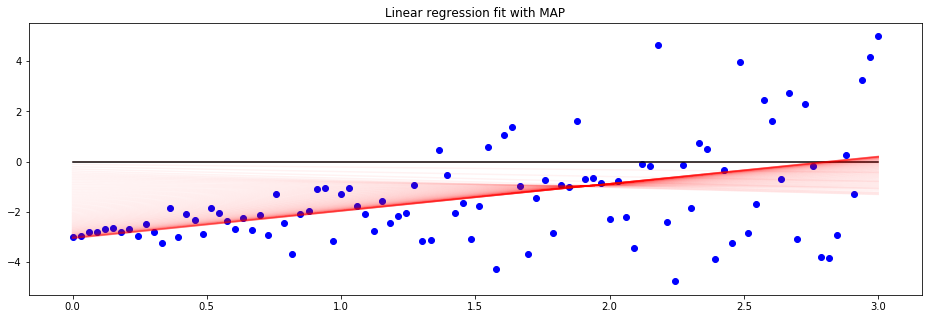

In [7]:
pred_model = lambda m, b: b + m*X

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(X, pred_model(0, 0), color='k') # Black line starting iteration
for t in opt_list:
    plt.plot(X, pred_model(t[3], t[2]), alpha=0.05, color='r')
plt.scatter(X, Y, color='b')
plt.title("Linear regression fit with MAP");

## Parameter estimation with MLE

In [8]:
# Resetting the parameters of the model
b0_v.assign(0); b1_v.assign(0);

In [9]:
opt_list = []
prob_values = []

for i in range(1000):
    loss_value, grads = grad_func(loss_MLE)
    optimizer.apply_gradients(zip(grads, [b0_v, b1_v]))
    if i % 10 == 0:
        print("Step: {}, initial loss: {}, b0: {}, b1: {}".format(
            optimizer.iterations.numpy(), 
            loss_value.numpy(), 
            b0_v.numpy(), 
            b1_v.numpy()))
        opt_list.append((
            optimizer.iterations.numpy(), 
            loss_value.numpy(), 
            b0_v.numpy(), 
            b1_v.numpy()))

b0_comparison["MLE"] = [it[-2] for it in opt_list]
b1_comparison["MLE"] = [it[-1] for it in opt_list]

Step: 1001, initial loss: 266.62457275390625, b0: -0.005741369444876909, b1: -0.010104884393513203
Step: 1011, initial loss: 264.9409484863281, b0: -0.2183913141489029, b1: -0.2987230718135834
Step: 1021, initial loss: 264.4736633300781, b0: -0.4527469277381897, b1: -0.41007575392723083
Step: 1031, initial loss: 263.9107360839844, b0: -0.6203756332397461, b1: -0.25131165981292725
Step: 1041, initial loss: 263.42730712890625, b0: -0.7753577828407288, b1: -0.07452031224966049
Step: 1051, initial loss: 263.04522705078125, b0: -0.9430862665176392, b1: 0.019618704915046692
Step: 1061, initial loss: 262.70721435546875, b0: -1.1078782081604004, b1: 0.07477711886167526
Step: 1071, initial loss: 262.42486572265625, b0: -1.255469560623169, b1: 0.14011791348457336
Step: 1081, initial loss: 262.1820983886719, b0: -1.3871196508407593, b1: 0.21594512462615967
Step: 1091, initial loss: 261.97454833984375, b0: -1.5090010166168213, b1: 0.2857142388820648
Step: 1101, initial loss: 261.796630859375, b0: 

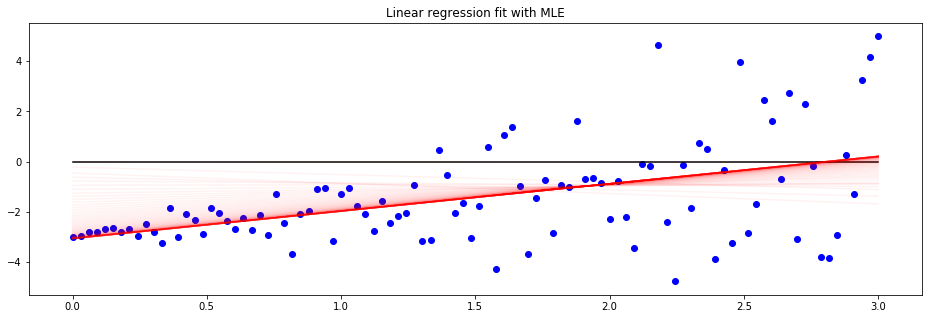

In [10]:
pred_model = lambda m, b: b + m*X

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(X, pred_model(0, 0), color='k') # Black line starting iteration
for t in opt_list:
    plt.plot(X, pred_model(t[3], t[2]), alpha=0.05, color='r')
plt.scatter(X, Y, color='b')
plt.title("Linear regression fit with MLE");

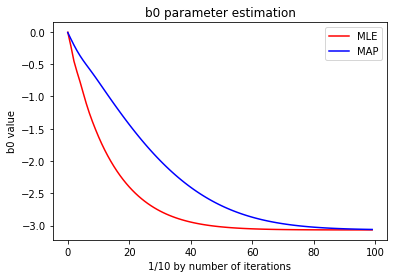

In [11]:
plt.plot(b0_comparison["MLE"], color='r', label="MLE")
plt.plot(b0_comparison["MAP"], color='b', label="MAP")
plt.title("b0 parameter estimation")
plt.ylabel("b0 value")
plt.xlabel("1/10 by number of iterations")
plt.legend(loc="upper right");

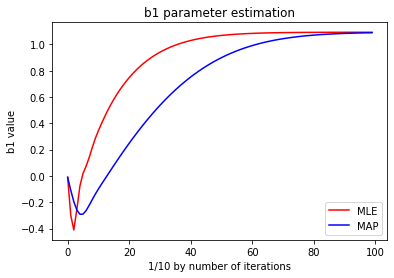

In [12]:
plt.plot(b1_comparison["MLE"], color='r', label="MLE")
plt.plot(b1_comparison["MAP"], color='b', label="MAP")
plt.title("b1 parameter estimation")
plt.xlabel("1/10 by number of iterations")
plt.ylabel("b1 value")
plt.legend(loc="lower right");

As you may see, MLE goes way faster than MAP, but in the end, similar results are obtained with both methods. The method of choice is up to you, but MAP takes into account the prior knowledge of the parameters to estimate the next value. The posterior will always be between the likelihood distribution and the prior, that's why the learning curves slow down for the case of MAP.